In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os, glob
import librosa
import librosa.display
import IPython
from IPython.display import Audio
from IPython.display import Image

In [2]:
!pip install torchinfo

In [3]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [4]:
emotions_dict ={
    '0':'surprised',
    '1':'neutral',
    '2':'calm',
    '3':'happy',
    '4':'sad',
    '5':'angry',
    '6':'fearful',
    '7':'disgust'
}


In [5]:
##### LOAD #########
# choose load file name
filename = "/content/gdrive/My Drive/thesis/Thesis/Pre Data/CREMA-D + RAVDESS.npy"

# open file in read mode and read data
with open(filename, 'rb') as f:
    X_train = np.load(f)
    X_valid = np.load(f)
    X_test = np.load(f)
    y_train = np.load(f)
    y_valid = np.load(f)
    y_test = np.load(f)

# Check that we've recovered the right data
print(f'X_train:{X_train.shape}, y_train:{y_train.shape}')
print(f'X_valid:{X_valid.shape}, y_valid:{y_valid.shape}')
print(f'X_test:{X_test.shape}, y_test:{y_test.shape}')

X_train:(17805, 1, 40, 282), y_train:(17805,)
X_valid:(2220, 1, 40, 282), y_valid:(2220,)
X_test:(2295, 1, 40, 282), y_test:(2295,)


In [6]:
class parallel_all_you_want(nn.Module):
    # Define all layers present in the network
    def __init__(self,num_emotions):
        super().__init__()

        ################ TRANSFORMER BLOCK #############################
        # maxpool the input feature map/tensor to the transformer
        # a rectangular kernel worked better here for the rectangular input spectrogram feature map/tensor
        self.transformer_maxpool = nn.MaxPool2d(kernel_size=[1,4], stride=[1,4])

        # define single transformer encoder layer
        # self-attention + feedforward network from "Attention is All You Need" paper
        # 4 multi-head self-attention layers each with 40-->512--->40 feedforward network
        transformer_layer = nn.TransformerEncoderLayer(
            d_model=40, # input feature (frequency) dim after maxpooling 40*282 -> 40*70 (MFC*time)
            nhead=4, # 4 self-attention layers in each multi-head self-attention layer in each encoder block
            dim_feedforward=512, # 2 linear layers in each encoder block's feedforward network: dim 40-->512--->40
            dropout=0.4,
            activation='relu' # ReLU: avoid saturation/tame gradient/reduce compute time
        )

        # I'm using 4 instead of the 6 identical stacked encoder layrs used in Attention is All You Need paper
        # Complete transformer block contains 4 full transformer encoder layers (each w/ multihead self-attention+feedforward)
        self.transformer_encoder = nn.TransformerEncoder(transformer_layer, num_layers=4)

        ############### 1ST PARALLEL 2D CONVOLUTION BLOCK ############
        # 3 sequential conv2D layers: (1,40,282) --> (16, 20, 141) -> (32, 5, 35) -> (64, 1, 8)
        self.conv2Dblock1 = nn.Sequential(

            # 1st 2D convolution layer
            nn.Conv2d(
                in_channels=1, # input volume depth == input channel dim == 1
                out_channels=16, # expand output feature map volume's depth to 16
                kernel_size=3, # typical 3*3 stride 1 kernel
                stride=1,
                padding=1
                      ),
            nn.BatchNorm2d(16), # batch normalize the output feature map before activation
            nn.ReLU(), # feature map --> activation map
            nn.MaxPool2d(kernel_size=2, stride=2), #typical maxpool kernel size
            nn.Dropout(p=0.3), #randomly zero 30% of 1st layer's output feature map in training

            # 2nd 2D convolution layer identical to last except output dim, maxpool kernel
            nn.Conv2d(
                in_channels=16,
                out_channels=32, # expand output feature map volume's depth to 32
                kernel_size=3,
                stride=1,
                padding=1
                      ),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=4), # increase maxpool kernel for subsequent filters
            nn.Dropout(p=0.3),

            # 3rd 2D convolution layer identical to last except output dim
            nn.Conv2d(
                in_channels=32,
                out_channels=64, # expand output feature map volume's depth to 64
                kernel_size=3,
                stride=1,
                padding=1
                      ),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=4),
            nn.Dropout(p=0.3),
        )
        ############### 2ND PARALLEL 2D CONVOLUTION BLOCK ############
        # 3 sequential conv2D layers: (1,40,282) --> (16, 20, 141) -> (32, 5, 35) -> (64, 1, 8)
        self.conv2Dblock2 = nn.Sequential(

            # 1st 2D convolution layer
            nn.Conv2d(
                in_channels=1, # input volume depth == input channel dim == 1
                out_channels=16, # expand output feature map volume's depth to 16
                kernel_size=3, # typical 3*3 stride 1 kernel
                stride=1,
                padding=1
                      ),
            nn.BatchNorm2d(16), # batch normalize the output feature map before activation
            nn.ReLU(), # feature map --> activation map
            nn.MaxPool2d(kernel_size=2, stride=2), #typical maxpool kernel size
            nn.Dropout(p=0.3), #randomly zero 30% of 1st layer's output feature map in training

            # 2nd 2D convolution layer identical to last except output dim, maxpool kernel
            nn.Conv2d(
                in_channels=16,
                out_channels=32, # expand output feature map volume's depth to 32
                kernel_size=3,
                stride=1,
                padding=1
                      ),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=4), # increase maxpool kernel for subsequent filters
            nn.Dropout(p=0.3),

            # 3rd 2D convolution layer identical to last except output dim
            nn.Conv2d(
                in_channels=32,
                out_channels=64, # expand output feature map volume's depth to 64
                kernel_size=3,
                stride=1,
                padding=1
                      ),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=4),
            nn.Dropout(p=0.3),
        )

        ################# FINAL LINEAR BLOCK ####################
        # Linear softmax layer to take final concatenated embedding tensor
        #    from parallel 2D convolutional and transformer blocks, output 8 logits
        # Each full convolution block outputs (64*1*8) embedding flattened to dim 512 1D array
        # Full transformer block outputs 40*70 feature map, which we time-avg to dim 40 1D array
        # 512*2+40 == 1064 input features --> 8 output emotions
        self.fc1_linear = nn.Linear(512*2+40,num_emotions)

        ### Softmax layer for the 8 output logits from final FC linear layer
        self.softmax_out = nn.Softmax(dim=1) # dim==1 is the freq embedding

    # define one complete parallel fwd pass of input feature tensor thru 2*conv+1*transformer blocks


    def forward(self,x):

        ############ 1st parallel Conv2D block: 4 Convolutional layers ############################
        # create final feature embedding from 1st convolutional layer
        # input features pased through 4 sequential 2D convolutional layers
        conv2d_embedding1 = self.conv2Dblock1(x) # x == N/batch * channel * freq * time

        # flatten final 64*1*8 feature map from convolutional layers to length 512 1D array
        # skip the 1st (N/batch) dimension when flattening
        conv2d_embedding1 = torch.flatten(conv2d_embedding1, start_dim=1)

        ############ 2nd parallel Conv2D block: 4 Convolutional layers #############################
        # create final feature embedding from 2nd convolutional layer
        # input features pased through 4 sequential 2D convolutional layers
        conv2d_embedding2 = self.conv2Dblock2(x) # x == N/batch * channel * freq * time

        # flatten final 64*1*8 feature map from convolutional layers to length 512 1D array
        # skip the 1st (N/batch) dimension when flattening
        conv2d_embedding2 = torch.flatten(conv2d_embedding2, start_dim=1)


        ########## 4-encoder-layer Transformer block w/ 40-->512-->40 feedfwd network ##############
        # maxpool input feature map: 1*40*282 w/ 1*4 kernel --> 1*40*70
        x_maxpool = self.transformer_maxpool(x)

        # remove channel dim: 1*40*70 --> 40*70
        x_maxpool_reduced = torch.squeeze(x_maxpool,1)

        # convert maxpooled feature map format: batch * freq * time ---> time * batch * freq format
        # because transformer encoder layer requires tensor in format: time * batch * embedding (freq)
        x = x_maxpool_reduced.permute(2,0,1)

        # finally, pass reduced input feature map x into transformer encoder layers
        transformer_output = self.transformer_encoder(x)

        # create final feature emedding from transformer layer by taking mean in the time dimension (now the 0th dim)
        # transformer outputs 2x40 (MFCC embedding*time) feature map, take mean of columns i.e. take time average
        transformer_embedding = torch.mean(transformer_output, dim=0) # dim 40x70 --> 40

        ############# concatenate freq embeddings from convolutional and transformer blocks ######
        # concatenate embedding tensors output by parallel 2*conv and 1*transformer blocks
        complete_embedding = torch.cat([conv2d_embedding1, conv2d_embedding2,transformer_embedding], dim=1)

        ######### final FC linear layer, need logits for loss #########################
        output_logits = self.fc1_linear(complete_embedding)

        ######### Final Softmax layer: use logits from FC linear, get softmax for prediction ######
        output_softmax = self.softmax_out(output_logits)

        # need output logits to compute cross entropy loss, need softmax probabilities to predict class
        return output_logits, output_softmax




In [7]:
import torchinfo
from torchinfo import summary


# Set device to CPU
device = 'cuda'

# Instantiate the model for 8 emotions and move to CPU
model = parallel_all_you_want(len(emotions_dict)).to(device)

summary(model, input_size=(1, 1, 40, 282), device=device)


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Layer (type:depth-idx)                        Output Shape              Param #
parallel_all_you_want                         [1, 8]                    --
├─Sequential: 1-1                             [1, 64, 1, 8]             --
│    └─Conv2d: 2-1                            [1, 16, 40, 282]          160
│    └─BatchNorm2d: 2-2                       [1, 16, 40, 282]          32
│    └─ReLU: 2-3                              [1, 16, 40, 282]          --
│    └─MaxPool2d: 2-4                         [1, 16, 20, 141]          --
│    └─Dropout: 2-5                           [1, 16, 20, 141]          --
│    └─Conv2d: 2-6                            [1, 32, 20, 141]          4,640
│    └─BatchNorm2d: 2-7                       [1, 32, 20, 141]          64
│    └─ReLU: 2-8                              [1, 32, 20, 141]          --
│    └─MaxPool2d: 2-9                         [1, 32, 5, 35]            --
│    └─Dropout: 2-10                          [1, 32, 5, 35]            --
│    └─Conv2d: 2

In [8]:
def criterion(predictions, targets):
    return nn.CrossEntropyLoss()(input=predictions, target=targets)


In [9]:
optimizer = torch.optim.SGD(model.parameters(),lr=0.01, weight_decay=1e-3, momentum=0.8)

In [10]:
def make_train_step(model, criterion, optimizer):

    # define the training step of the training phase
    def train_step(X,Y):

        # forward pass
        output_logits, output_softmax = model(X)
        predictions = torch.argmax(output_softmax,dim=1)
        accuracy = torch.sum(Y==predictions)/float(len(Y))

        # compute loss on logits because nn.CrossEntropyLoss implements log softmax
        loss = criterion(output_logits, Y)

        # compute gradients for the optimizer to use
        loss.backward()

        # update network parameters based on gradient stored (by calling loss.backward())
        optimizer.step()

        # zero out gradients for next pass
        # pytorch accumulates gradients from backwards passes (convenient for RNNs)
        optimizer.zero_grad()

        return loss.item(), accuracy*100
    return train_step

In [11]:
def make_validate_fnc(model,criterion):
    def validate(X,Y):

        # don't want to update any network parameters on validation passes: don't need gradient
        # wrap in torch.no_grad to save memory and compute in validation phase:
        with torch.no_grad():

            # set model to validation phase i.e. turn off dropout and batchnorm layers
            model.eval()

            # get the model's predictions on the validation set
            output_logits, output_softmax = model(X)
            predictions = torch.argmax(output_softmax,dim=1)

            # calculate the mean accuracy over the entire validation set
            accuracy = torch.sum(Y==predictions)/float(len(Y))

            # compute error from logits (nn.crossentropy implements softmax)
            loss = criterion(output_logits,Y)

        return loss.item(), accuracy*100, predictions
    return validate

In [12]:
def make_save_checkpoint():
    def save_checkpoint(optimizer, model, epoch, filename):
        checkpoint_dict = {
            'optimizer': optimizer.state_dict(),
            'model': model.state_dict(),
            'epoch': epoch
        }
        torch.save(checkpoint_dict, filename)
    return save_checkpoint

def load_checkpoint(optimizer, model, filename):
    checkpoint_dict = torch.load(filename)
    epoch = checkpoint_dict['epoch']
    model.load_state_dict(checkpoint_dict['model'])
    if optimizer is not None:
        optimizer.load_state_dict(checkpoint_dict['optimizer'])
    return epoch

In [13]:
# get training set size to calculate # iterations and minibatch indices
train_size = X_train.shape[0]

# pick minibatch size (of 32... always)
minibatch = 32

# set device to GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'{device} selected')

# instantiate model and move to GPU for training
model = parallel_all_you_want(num_emotions=(len(emotions_dict))).to(device)
print('Number of trainable params: ',sum(p.numel() for p in model.parameters()) )

# encountered bugs in google colab only, unless I explicitly defined optimizer in this cell...
optimizer = torch.optim.SGD(model.parameters(),lr=0.01, weight_decay=1e-3, momentum=0.8)

# instantiate the checkpoint save function
save_checkpoint = make_save_checkpoint()

# instantiate the training step function
train_step = make_train_step(model, criterion, optimizer=optimizer)

# instantiate the validation loop function
validate = make_validate_fnc(model,criterion)

# instantiate lists to hold scalar performance metrics to plot later
train_losses=[]
valid_losses = []

# create training loop for one complete epoch (entire training set)
def train(optimizer, model, num_epochs, X_train, Y_train, X_valid, Y_valid):

    for epoch in range(num_epochs):

        # set model to train phase
        model.train()

        # shuffle entire training set in each epoch to randomize minibatch order
        train_indices = np.random.permutation(train_size)

        # shuffle the training set for each epoch:
        X_train = X_train[train_indices,:,:,:]
        Y_train = Y_train[train_indices]

        # instantiate scalar values to keep track of progress after each epoch so we can stop training when appropriate
        epoch_acc = 0
        epoch_loss = 0
        num_iterations = int(train_size / minibatch)

        # create a loop for each minibatch of 32 samples:
        for i in range(num_iterations):

            # we have to track and update minibatch position for the current minibatch
            # if we take a random batch position from a set, we almost certainly will skip some of the data in that set
            # track minibatch position based on iteration number:
            batch_start = i * minibatch
            # ensure we don't go out of the bounds of our training set:
            batch_end = min(batch_start + minibatch, train_size)
            # ensure we don't have an index error
            actual_batch_size = batch_end-batch_start

            # get training minibatch with all channnels and 2D feature dims
            X = X_train[batch_start:batch_end,:,:,:]
            # get training minibatch labels
            Y = Y_train[batch_start:batch_end]

            # instantiate training tensors
            X_tensor = torch.tensor(X, device=device).float()
            Y_tensor = torch.tensor(Y, dtype=torch.long,device=device)

            # Pass input tensors thru 1 training step (fwd+backwards pass)
            loss, acc = train_step(X_tensor,Y_tensor)

            # aggregate batch accuracy to measure progress of entire epoch
            epoch_acc += acc * actual_batch_size / train_size
            epoch_loss += loss * actual_batch_size / train_size

            # keep track of the iteration to see if the model's too slow
            print('\r'+f'Epoch {epoch}: iteration {i}/{num_iterations}',end='')

        # create tensors from validation set
        X_valid_tensor = torch.tensor(X_valid,device=device).float()
        Y_valid_tensor = torch.tensor(Y_valid,dtype=torch.long,device=device)

        # calculate validation metrics to keep track of progress; don't need predictions now
        valid_loss, valid_acc, _ = validate(X_valid_tensor,Y_valid_tensor)

        # accumulate scalar performance metrics at each epoch to track and plot later
        train_losses.append(epoch_loss)
        valid_losses.append(valid_loss)

        # Save checkpoint of the model
        checkpoint_filename = '/content/gdrive/My Drive/thesis/Thesis/Checkpoint/parallel_all_you_wantFINAL-{:03d}.pkl'.format(epoch)
        save_checkpoint(optimizer, model, epoch, checkpoint_filename)

        # keep track of each epoch's progress
        print(f'\nEpoch {epoch} --- loss:{epoch_loss:.3f}, Epoch accuracy:{epoch_acc:.2f}%, Validation loss:{valid_loss:.3f}, Validation accuracy:{valid_acc:.2f}%')


cuda selected
Number of trainable params:  248488


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [14]:
print(model)

parallel_all_you_want(
  (transformer_maxpool): MaxPool2d(kernel_size=[1, 4], stride=[1, 4], padding=0, dilation=1, ceil_mode=False)
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-3): 4 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=40, out_features=40, bias=True)
        )
        (linear1): Linear(in_features=40, out_features=512, bias=True)
        (dropout): Dropout(p=0.4, inplace=False)
        (linear2): Linear(in_features=512, out_features=40, bias=True)
        (norm1): LayerNorm((40,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((40,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.4, inplace=False)
        (dropout2): Dropout(p=0.4, inplace=False)
      )
    )
  )
  (conv2Dblock1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, af

In [15]:
# choose number of epochs higher than reasonable so we can manually stop training
num_epochs = 500

# train it!
train(optimizer, model, num_epochs, X_train, y_train, X_valid, y_valid)

Epoch 0: iteration 555/556
Epoch 0 --- loss:1.897, Epoch accuracy:32.86%, Validation loss:1.702, Validation accuracy:33.83%
Epoch 1: iteration 555/556
Epoch 1 --- loss:1.477, Epoch accuracy:41.22%, Validation loss:1.520, Validation accuracy:40.90%
Epoch 2: iteration 555/556
Epoch 2 --- loss:1.392, Epoch accuracy:44.96%, Validation loss:1.427, Validation accuracy:45.36%
Epoch 3: iteration 555/556
Epoch 3 --- loss:1.346, Epoch accuracy:47.07%, Validation loss:1.443, Validation accuracy:44.41%
Epoch 4: iteration 555/556
Epoch 4 --- loss:1.308, Epoch accuracy:48.15%, Validation loss:1.425, Validation accuracy:44.91%
Epoch 5: iteration 555/556
Epoch 5 --- loss:1.276, Epoch accuracy:49.83%, Validation loss:1.392, Validation accuracy:46.58%
Epoch 6: iteration 555/556
Epoch 6 --- loss:1.249, Epoch accuracy:51.04%, Validation loss:1.351, Validation accuracy:48.65%
Epoch 7: iteration 555/556
Epoch 7 --- loss:1.223, Epoch accuracy:52.30%, Validation loss:1.335, Validation accuracy:48.78%
Epoch 8:

KeyboardInterrupt: 

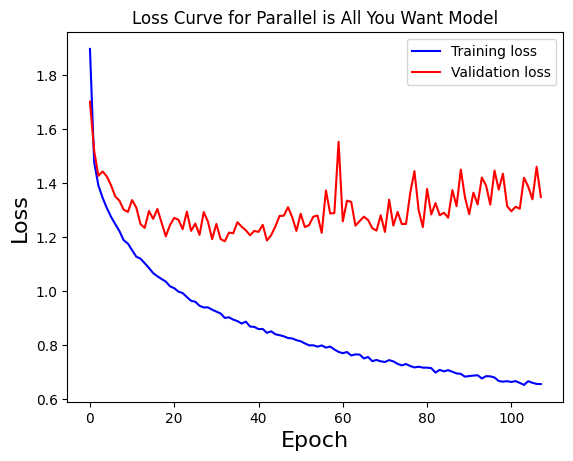

In [16]:
plt.title('Loss Curve for Parallel is All You Want Model')
plt.ylabel('Loss', fontsize=16)
plt.xlabel('Epoch', fontsize=16)
plt.plot(train_losses[:],'b')
plt.plot(valid_losses[:],'r')
plt.legend(['Training loss','Validation loss'])
plt.show()

In [17]:
# pick load folder
load_folder = '/content/gdrive/My Drive/thesis/Thesis/Checkpoint'

# pick the epoch to load
epoch = '100'
model_name = f'parallel_all_you_wantFINAL-{epoch}.pkl'

# make full load path
load_path = os.path.join(load_folder, model_name)

## instantiate empty model and populate with params from binary
model = parallel_all_you_want(len(emotions_dict))
load_checkpoint(optimizer, model, load_path)

print(f'Loaded model from {load_path}')

Loaded model from /content/gdrive/My Drive/thesis/Thesis/Checkpoint/parallel_all_you_wantFINAL-100.pkl


<ipython-input-12-b5969c66fb59>:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_dict = torch.load(filename)


In [18]:
# Reinitialize validation function with model moved to GPU
model = model.to(device)  # Move the model to the GPU
validate = make_validate_fnc(model, criterion)

# Convert 4D test feature set array to tensor and move to GPU
X_test_tensor = torch.tensor(X_test, device=device).float()

# Convert 4D test label set array to tensor and move to GPU
y_test_tensor = torch.tensor(y_test, dtype=torch.long, device=device)

# Get the model's performance metrics using the validation function we defined
test_loss, test_acc, predicted_emotions = validate(X_test_tensor, y_test_tensor)

print(f'Test accuracy is {test_acc:.2f}%')


Test accuracy is 51.81%


In [19]:
def predict(X,model):

    # don't want to update any network parameters on validation passes: don't need gradient
    # wrap in torch.no_grad to save memory and compute in validation phase:
    with torch.no_grad():

        # set model to validation phase i.e. turn off dropout and batchnorm layers
        model.eval()

        # get the model's predictions on the validation set
        output_logits, output_softmax = model(X)
        predictions = torch.argmax(output_softmax,dim=1)

        # calculate the mean accuracy over the entire validation set


        # compute error from logits (nn.crossentropy implements softmax)


    return predictions

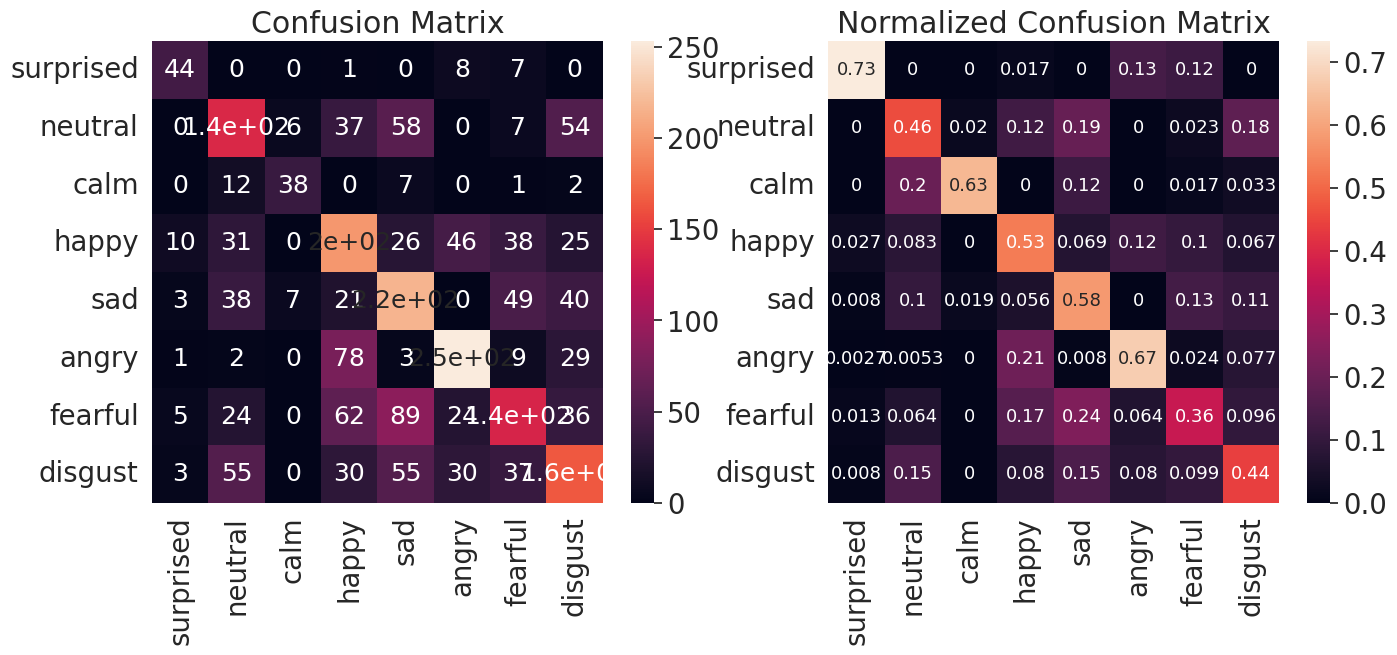

In [20]:
from sklearn.metrics import confusion_matrix
import seaborn as sn

# because model tested on GPU, move prediction tensor to CPU then convert to array
predicted_emotions = predicted_emotions.cpu().numpy()
# use labels from test set
emotions_groundtruth = y_test

# build confusion matrix and normalized confusion matrix
conf_matrix = confusion_matrix(emotions_groundtruth, predicted_emotions)
conf_matrix_norm = confusion_matrix(emotions_groundtruth, predicted_emotions,normalize='true')

# set labels for matrix axes from emotions
emotion_names = [emotion for emotion in emotions_dict.values()]

# make a confusion matrix with labels using a DataFrame
confmatrix_df = pd.DataFrame(conf_matrix, index=emotion_names, columns=emotion_names)
confmatrix_df_norm = pd.DataFrame(conf_matrix_norm, index=emotion_names, columns=emotion_names)

# plot confusion matrices
plt.figure(figsize=(16,6))
sn.set(font_scale=1.8) # emotion label and title size
plt.subplot(1,2,1)
plt.title('Confusion Matrix')
sn.heatmap(confmatrix_df, annot=True, annot_kws={"size": 18}) #annot_kws is value font
plt.subplot(1,2,2)
plt.title('Normalized Confusion Matrix')
sn.heatmap(confmatrix_df_norm, annot=True, annot_kws={"size": 13}) #annot_kws is value font

plt.show()

In [21]:
test = X_test[50:100,:,:,:]
test_tensor = torch.tensor(test, device=device).float()
print(test_tensor.shape)
pred = predict(test_tensor,model)
pred

torch.Size([50, 1, 40, 282])


tensor([3, 5, 1, 3, 6, 7, 3, 6, 5, 3, 6, 3, 0, 3, 4, 0, 6, 3, 3, 0, 4, 6, 4, 4,
        2, 0, 6, 4, 4, 4, 7, 4, 6, 4, 3, 4, 4, 6, 2, 1, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 5], device='cuda:0')